In [4]:
# Importing Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [5]:
def prepare_features():
    # Load data
    customers_df = pd.read_csv('Customers.csv')
    transactions_df = pd.read_csv('Transactions.csv')

    # Convert dates
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    # Create customer features
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean'],
        'TransactionDate': lambda x: (x.max() - x.min()).days
    }).reset_index()

    # Flatten column names
    transaction_features.columns = [
        'CustomerID', 'transaction_count', 'total_spend',
        'avg_transaction_value', 'total_quantity', 'avg_quantity',
        'purchase_timespan'
    ]

    # Calculate recency
    latest_date = transactions_df['TransactionDate'].max()
    last_purchase = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - last_purchase).dt.days
    transaction_features['recency'] = recency

    # Encode regions
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')

    # Calculate signup recency
    latest_signup = customers_df['SignupDate'].max()
    customers_df['signup_recency'] = (latest_signup - customers_df['SignupDate']).dt.days

    # Merge features
    feature_columns = ['CustomerID', 'signup_recency']
    customer_features = pd.merge(
        customers_df[feature_columns],
        transaction_features,
        on='CustomerID',
        how='left'
    )
    customer_features = pd.concat([customer_features, region_dummies], axis=1)

    # Fill NaN values
    customer_features = customer_features.fillna(0)

    return customer_features

In [6]:
def calculate_db_index(X, labels):
    # Calculate cluster centers
    unique_labels = np.unique(labels)
    centers = np.array([X[labels == i].mean(axis=0) for i in unique_labels])

    # Calculate average distances within clusters
    cluster_distances = []
    for i in unique_labels:
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:
            distances = pdist(cluster_points)
            cluster_distances.append(np.mean(distances))
        else:
            cluster_distances.append(0)

    # Calculate distances between clusters
    center_distances = pdist(centers)
    center_distances = squareform(center_distances)

    # Calculate DB Index
    db_index = 0
    n_clusters = len(unique_labels)

    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                ratio = (cluster_distances[i] + cluster_distances[j]) / center_distances[i][j]
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio

    return db_index / n_clusters

Preparing customer features...

Finding optimal number of clusters...
Clusters: 2
Silhouette Score: 0.1666
DB Index: 2.6925

Clusters: 3
Silhouette Score: 0.1402
DB Index: 2.9229

Clusters: 4
Silhouette Score: 0.1554
DB Index: 2.6628

Clusters: 5
Silhouette Score: 0.2743
DB Index: 1.8841

Clusters: 6
Silhouette Score: 0.2604
DB Index: 1.8607

Clusters: 7
Silhouette Score: 0.2380
DB Index: 1.9296

Clusters: 8
Silhouette Score: 0.2498
DB Index: 1.8668

Clusters: 9
Silhouette Score: 0.2543
DB Index: 1.8808

Clusters: 10
Silhouette Score: 0.2298
DB Index: 1.9715


Optimal number of clusters: 6

Cluster Analysis:
         transaction_count  total_spend  avg_transaction_value  recency  \
Cluster                                                                   
0                     8.19      6264.75                 776.89      0.0   
1                     5.07      3646.56                 730.01      0.0   
2                     2.00       599.71                 293.95      0.0   
3        

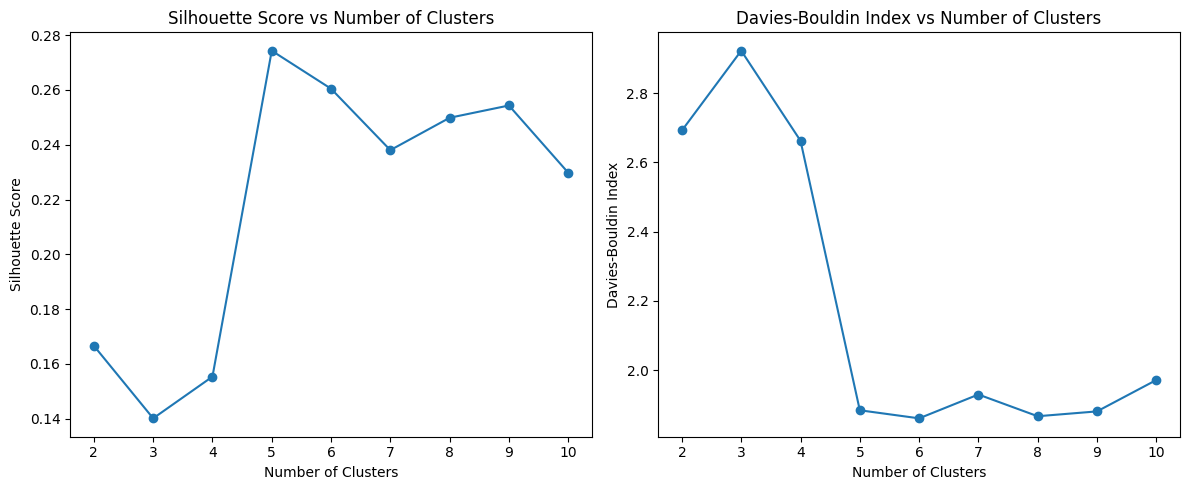

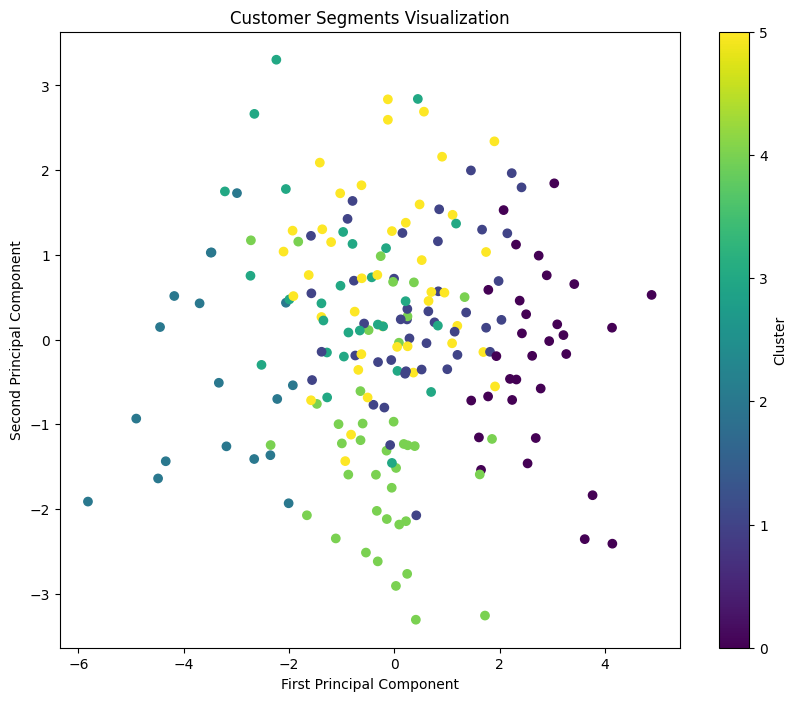

In [7]:
def main():
    # Prepare features
    print("Preparing customer features...")
    customer_features = prepare_features()

    # Select features for clustering
    feature_cols = [col for col in customer_features.columns
                   if col not in ['CustomerID']]

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(customer_features[feature_cols])

    # Find optimal number of clusters
    print("\nFinding optimal number of clusters...")
    max_clusters = 10
    scores = []
    db_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)

        silhouette = silhouette_score(X, labels)
        db_index = calculate_db_index(X, labels)

        scores.append(silhouette)
        db_scores.append(db_index)

        print(f"Clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"DB Index: {db_index:.4f}\n")

    # Plot evaluation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index vs Number of Clusters')

    plt.tight_layout()
    plt.savefig('clustering_metrics.png')

    # Select optimal number of clusters (based on metrics)
    optimal_clusters = np.argmin(db_scores) + 2
    print(f"\nOptimal number of clusters: {optimal_clusters}")

    # Final clustering
    final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    labels = final_kmeans.fit_predict(X)

    # Add cluster labels to features
    customer_features['Cluster'] = labels

    # Analyze clusters
    cluster_analysis = customer_features.groupby('Cluster').agg({
        'transaction_count': 'mean',
        'total_spend': 'mean',
        'avg_transaction_value': 'mean',
        'recency': 'mean',
        'CustomerID': 'count'
    }).round(2)

    print("\nCluster Analysis:")
    print(cluster_analysis)

    # Visualize clusters (2D projection using PCA)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Customer Segments Visualization')
    plt.colorbar(scatter, label='Cluster')
    plt.savefig('cluster_visualization.png')

    # Save results
    customer_features.to_csv('customer_segments.csv', index=False)
    cluster_analysis.to_csv('cluster_analysis.csv')

    print("\nResults saved to:")
    print("- customer_segments.csv")
    print("- cluster_analysis.csv")
    print("- clustering_metrics.png")
    print("- cluster_visualization.png")

if __name__ == "__main__":
    main()